In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays as hd

from time import time
import datetime
import random

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

## Loading Data

In [ ]:
# Set main working directory and secondary folder paths
directory = os.getcwd() # get working directory
data_path = directory + "/data/"
models_path = directory + "/models/"

In [ ]:
# Read the relevant weather data from the weather.csv file
weather = pd.read_csv(data_path+'weather'+'.csv')
weather.columns = weather.iloc[1]
weather = weather.iloc[2:]
weather['date'] = pd.to_datetime(weather['time']) # convert timestamps to dates
weather = weather.loc[weather['date'] >= '2015-01-01 00:00:00'] # keep data from 2015 onwards
weather.index = weather['date'] # set the date as the index
weather = weather[['temperature', 'irradiance_surface', 'precipitation', 'cloud_cover']]

<ipython-input-70-3c3c69d1651e>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(data_path+'weather'+'.csv')


In [ ]:
# Read the relevant consumption data from the consumption.csv file
consumption = pd.read_csv(data_path+'consumption'+'.csv')
consumption['date'] = pd.to_datetime(consumption['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ') # convert timestamps to dates
consumption.index = consumption['date'] # set the date as the index
consumption = pd.DataFrame(consumption['ES_load_actual_entsoe_transparency'][1:])
consumption.columns = ['load']

In [ ]:
# combine consumption and weather data into a single dataframe
data = pd.concat([consumption, weather], axis=1)
data

,load,temperature,irradiance_surface,precipitation,cloud_cover
date,,,,,
2015-01-01 00:00:00,NaN,3.438,0.0,0.0002,0.1066
2015-01-01 01:00:00,22734.0,3.217,0.0,0.0003,0.1254
2015-01-01 02:00:00,21286.0,3.103,0.0,0.0004,0.121
2015-01-01 03:00:00,20264.0,3.051,0.0,0.0004,0.095
2015-01-01 04:00:00,19905.0,2.982,0.0,0.0003,0.083
...,...,...,...,...,...
2019-12-31 19:00:00,29362.0,8.295,0.0,0.0001,0.1557
2019-12-31 20:00:00,27608.0,7.805,0.0,0.0001,0.1382
2019-12-31 21:00:00,25241.0,7.342,0.0,0.0003,0.1363


In [ ]:
# Look for NaN values
print(f'A total of {data.isnull().values.sum()} NaN values:\n')
data.index[data.isnull().any(axis=1)]

A total of 19 NaN values:



DatetimeIndex(['2015-01-01 00:00:00', '2015-01-02 06:00:00',
               '2015-01-02 07:00:00', '2015-01-02 08:00:00',
               '2015-01-02 11:00:00', '2015-01-02 12:00:00',
               '2015-01-02 13:00:00', '2015-01-02 14:00:00',
               '2015-01-02 15:00:00', '2015-01-02 16:00:00',
               '2015-01-02 17:00:00', '2015-01-02 18:00:00',
               '2015-05-01 10:00:00', '2015-05-01 11:00:00',
               '2015-05-01 12:00:00', '2015-05-01 13:00:00',
               '2015-05-01 14:00:00', '2015-05-01 15:00:00',
               '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
def fill_nan(df):
  """
  Replaces NaN values by using the forward and backward fill method.

  Args
  ---------
  pd.DataFrame df: the original dataframe with NaN values

  Returns
  -------
  pd.DataFrame df: the cleaned dataframe
  """
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
# Fix NaN values
data = fill_nan(data)

In [ ]:
legends = {
    0: 'Load (MW)',
    1: 'Temperature (C)',
    2: 'Irradiance (W/m^2)',
    3: 'Precipitation (mm/hour)',
    4: 'Cloud Cover [0,1]'
}

colors = sns.color_palette()
sns.set_theme(style='darkgrid')

## Preprocessing

### Z-score outlier detection

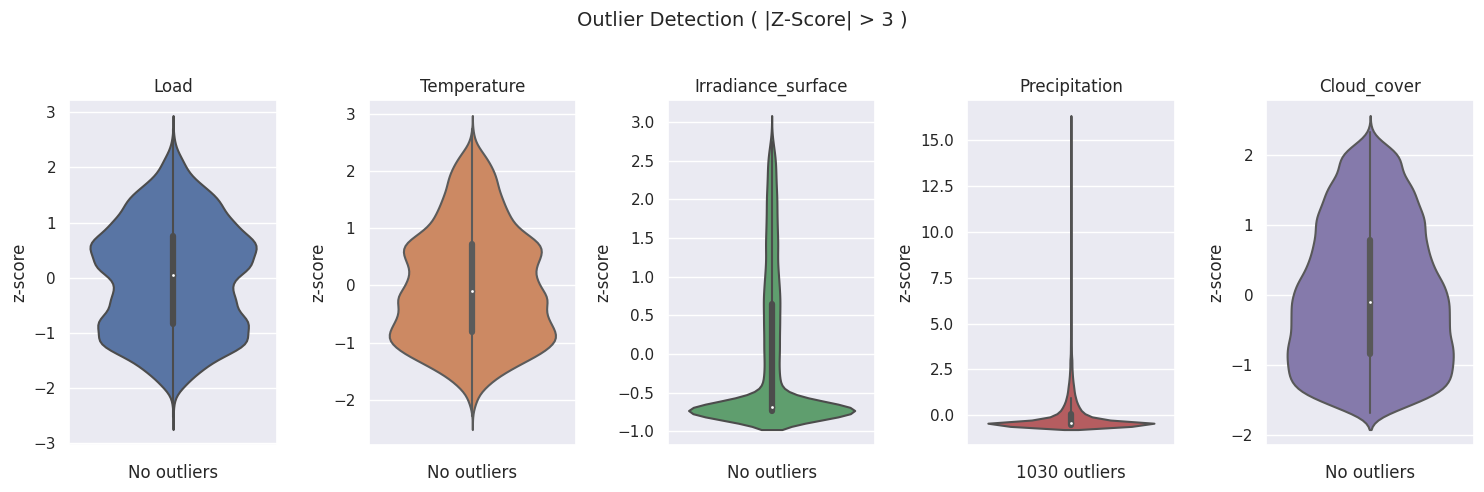

In [ ]:
def find_outliers(df):
  """
  Finds and plots outliers on each feature of a dataframe.

  Args
  ---------
  pd.DataFrame df: the original dataframe
  """
  # Create as many sublplots as the features
  fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

  # for every feature of the data set
  for i, feature in enumerate(df.columns):
    d = df[feature]

    # calculate the Z-score of each data point
    z_scores = (d - d.mean()) / d.std()

    # identify any points with a Z-score > 3
    outliers = d[abs(z_scores) > 3]

    # create plot showing if there are any outliers
    sns.violinplot(data=z_scores, ax=axes[i], color=colors[i])

    title = 'No outliers'
    if len(outliers) > 0:
      title = f'{len(outliers)} outliers'

    axes[i].set_title(feature.capitalize())
    axes[i].set_ylabel('z-score')
    axes[i].set_xlabel(title)
    axes[i].set_xticklabels('')

  fig.suptitle("Outlier Detection ( |Z-Score| > 3 )\n", fontsize=14)
  plt.tight_layout()
  plt.show()
  return

colors = sns.color_palette()
sns.set_theme(style='darkgrid')
find_outliers(data)

### Augmentation

In [ ]:
# create a one-hot encoded day category dataframe
weekday_map = {'Monday':    'mon',
               'Tuesday':   'wkd',
               'Wednesday': 'wkd',
               'Thursday':  'wkd',
               'Friday':    'fri',
               'Saturday':  'wkn',
               'Sunday':    'wkn'}

day_cat = pd.get_dummies(data.index.day_name().map(weekday_map))[['mon', 'wkd', 'fri', 'wkn']]
day_cat

,mon,wkd,fri,wkn
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
43819,0,1,0,0
43820,0,1,0,0
43821,0,1,0,0
43822,0,1,0,0


In [ ]:
# # retrieve holiday list dictionary from the top-4 most populated provinces
years = range(2015, 2020)
provinces = ['MD', 'AN', 'CT', 'VC'] # [Madrid, Andalusia, Catalonia, Valencia]
holiday_list = hd.ES(years=years, prov=provinces[0])
for province in provinces:
  holiday_list.update(hd.ES(years=years, prov=province))

print(f'Number of total holidays: {len(holiday_list)}')

# create binary dataframe with value=1 if the day is a holiday
holidays = pd.DataFrame(data.index)
holidays['hld'] = 0
holidays.loc[holidays['date'].apply(lambda d: d in holiday_list), 'hld'] = 1
holidays = pd.DataFrame(holidays['hld'])
holidays.index = data.index
holidays

Number of total holidays: 92


,hld
date,
2015-01-01 00:00:00,1
2015-01-01 01:00:00,1
2015-01-01 02:00:00,1
2015-01-01 03:00:00,1
2015-01-01 04:00:00,1
...,...
2019-12-31 19:00:00,0
2019-12-31 20:00:00,0
2019-12-31 21:00:00,0


### Transformation

In [ ]:
# convert load from MW to GW
data['load'] /= 1000.0

In [ ]:
# Use Standard Scaliner to normalize all the unique data features
scalers = {}

for feature in data.columns:
  scaler = StandardScaler()
  data[feature] = scaler.fit_transform(np.array(data[feature]).reshape(-1, 1))
  scalers.update({feature: scaler})

In [ ]:
data.describe()

,load,temperature,irradiance_surface,precipitation,cloud_cover
count,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04
mean,4.864066e-16,3.320536e-16,-2.594168e-17,-6.744838e-17,-1.219259e-16
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.518242e+00,-2.283490e+00,-7.421028e-01,-5.498245e-01,-1.687913e+00
25%,-8.471838e-01,-8.177143e-01,-7.421028e-01,-5.273822e-01,-8.391267e-01
50%,4.471504e-02,-1.044044e-01,-6.896978e-01,-4.056754e-01,-1.042268e-01
75%,7.615632e-01,7.168984e-01,6.509381e-01,6.043541e-02,7.755073e-01
max,2.704697e+00,2.733647e+00,2.845695e+00,1.611623e+01,2.320819e+00


## Feature Extraction

```
[ X data ]
--------------------------------
H1. Consumption   Nd X 24h
H2. Temperature   Nd X 24h
H3. Irradiance    Nd X 24h
H4. Precipitation Nd X 24h
H5. Cloud Cover   Nd X 24h

F1. Temperature Forecast   24h
F2. Irradiance Forecast    24h
F3. Precipitation Forecast 24h
F4. Cloud Cover Forecast   24h

C1. Day-ahead Day Number    1
C2. Day-ahead Month Number  1
C3. Day-ahead Day Category  4
C4. Day-ahead Holiday       1

[ Y data ]
--------------------------------
Y1. Consumption Forecast 24h
```

In [ ]:
def extract_features(days_back, data, day_cat, holidays):
  """
  Calculates feature vectors, specified by the days_back properties
  dictionary and returns the X and Y arrays with the preprocessed data.

  Args
  ---------
  dict days_back: properties for days_back count to be considered for feature vectors
  pd.DataFrame data: concatenated consumption and weather data features
  pd.DataFrame day_cat: one-hot encoded day category dataframe
  pd.DataFrame holidays: binary holiday indicator dataframe

  Returns
  -------
  np.ndarray X: shape=(n_days, n_features), represents input x data
  np.ndarray Y: shape=(n_days, 24), represents target y data
  """
  X = []
  Y = []

  first_black_day = max(days_back.values()) # find the first black day

  # iterate through all black days
  for day_id in range(first_black_day, (data.shape[0]-24)//24):

    # Calculate historical load and weather features
    H1 = data['load'].iloc[(day_id-days_back['load'])*24:(day_id)*24]
    H2 = data['temperature'].iloc[(day_id-days_back['temperature'])*24:(day_id)*24]
    H3 = data['irradiance_surface'].iloc[(day_id-days_back['irradiance_surface'])*24:(day_id)*24]
    H4 = data['precipitation'].iloc[(day_id-days_back['precipitation'])*24:(day_id)*24]
    H5 = data['cloud_cover'].iloc[(day_id-days_back['cloud_cover'])*24:(day_id)*24]

    next24h = range((day_id)*24, (day_id+1)*24) # calculate the range for the next 24h (used for weather forecasts)
    next1d = (day_id+1)*24 # the id of the next day

    # Calculate simulated day-ahead weather forecast
    F1 = data['temperature'].iloc[next24h]
    F2 = data['irradiance_surface'].iloc[next24h]
    F3 = data['precipitation'].iloc[next24h]
    F4 = data['cloud_cover'].iloc[next24h]

    # Retrieve day-ahead calendar features
    C1 = int(data.index.day[next1d])
    C2 = int(data.index.month[next1d])
    C3 = np.array(day_cat.iloc[next1d])
    C4 = int(holidays.iloc[next1d])
    calendar = np.concatenate((np.array([C1, C2]), C3, np.array([C4])))

    # Create the X feature vector by combining all of the above
    feature_vec = np.concatenate((H1, H2, H3, H4, H5, F1, F2, F3, F4, calendar))
    X.append(feature_vec)

    # Create the Y feature vector by retrieving the actual day-ahead load values
    Y1 = data['load'].iloc[(day_id+1)*24:(day_id+2)*24]
    Y.append(np.array(Y1))

  return np.array(X, dtype='float64'), np.array(Y, dtype='float64')

In [ ]:
def split_train_test_val(A):
  """
  Splits data into train, validation and test sets.

  Args
  ---------
  np.ndarray A: shape=(n_days, n_features) feature vector table

  Returns
  -------
  np.ndarray train: the train set
  np.ndarray val:   the validation set
  np.ndarray test:  the test set
  """

  n_instances = A.shape[0]

  n_val = 365  # Keep a year's worth of validation data
  n_test = 365 # Keep a year's worth of testing data
  n_train = n_instances - n_val - n_test # Leave the rest for training

  indices = range(A.shape[0])

  train = A[indices[:n_train]] # Years 2015-2017: training data
  val   = A[indices[n_train:n_train+n_val]] # Year 2018: validation data
  test  = A[indices[n_train+n_val:]] # Year 2019: testing data

  return train, val, test

In [ ]:
# specifies the days_back amount that will be considered for each historical feature value (H1-H5)
days_back = {
    'load': 7,
    'temperature': 7,
    'irradiance_surface': 7,
    'precipitation': 7,
    'cloud_cover': 7,
}

In [ ]:
# extract features and print shapes
X, Y = extract_features(days_back, data, day_cat, holidays)
n_features = X.shape[1]
print(X.shape, Y.shape)

(1818, 943) (1818, 24)


In [ ]:
# split the data into train, validation and test sets
x_train, x_val, x_test = split_train_test_val(X)
y_train, y_val, y_test = split_train_test_val(Y)

In [ ]:
# confirm that the shapes are as needed
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1088, 943) (365, 943) (365, 943)
(1088, 24) (365, 24) (365, 24)
